<a href="https://colab.research.google.com/github/snjugunanjenga/digicow-churn-prediction-zindi-africa/blob/main/winning_strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Step-by-Step Contextual Outline
Advanced Text Vectorization: Instead of just keywords, we will use TF-IDF (Term Frequency-Inverse Document Frequency) to find which topics are truly unique and influential for adoption.

K-Fold Target Encoding (K-TE): We will encode trainer and ward success rates using a 5-fold out-of-fold method to prevent data leakage while capturing the localized "conversion rate."

Cross-Validation with Calibration: We will wrap our models in a CalibratedClassifierCV to ensure the Log Loss is minimized.

Ensembling (The Top 5 Secret): We will blend a CatBoost model (best for categorical data) with an XGBoost model (best for capturing structural patterns) to create a robust final probability.

## 1: Environment & Professional Setup

In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.4 MB/s eta 0:00:00


In [18]:
import pandas as pd
import numpy as np
import ast, os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import CalibratedClassifierCV
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import log_loss, roc_auc_score
import matplotlib.pyplot as plt

In [5]:
from google.colab import drive
drive.mount('/content/drive')

# Define paths
DATA_PATH = '/content/drive/MyDrive/Zindi/Digicow/data/'

Mounted at /content/drive


In [6]:
train = pd.read_csv(DATA_PATH + 'Train.csv')
test = pd.read_csv(DATA_PATH + 'Test.csv')

In [7]:
train.head(5)

,ID,gender,age,registration,belong_to_cooperative,county,subcounty,ward,trainer,first_training_date,topics_list,num_total_trainings,num_repeat_trainings,days_to_second_training,num_unique_trainers,adopted_within_07_days,adopted_within_90_days,adopted_within_120_days,has_second_training
0,ID_A2UAZE,Female,Below 35,Ussd,0,Bungoma,Bumula,Kabula,trainer_name_2,2024-02-23,"['Ndume App,Poultry Feeding']",1,0,NaN,1,0,0,0,0
1,ID_RM2GTJ,Female,Below 35,Ussd,0,Bungoma,Bumula,Kabula,trainer_name_2,2024-02-24,"['Herd Management,Ndume App,Poultry Feeding,Po...",1,0,NaN,1,0,0,0,0
2,ID_5J3VCK,Male,Above 35,Ussd,0,Nyamira,North Mugirango,Bomwagamo,trainer_name_4,2024-02-21,"['Disadvantages Of Natural Mating', 'Poultry F...",39,38,0.0,1,1,1,1,1
3,ID_2PGL0A,Female,Above 35,Manual,0,Nyamira,North Mugirango,Bomwagamo,trainer_name_4,2024-02-29,"['Factors Affecting Milk Production', 'Factors...",301,300,0.0,1,1,1,1,1
4,ID_K1XGMR,Female,Above 35,Ussd,0,Nyamira,North Mugirango,Bomwagamo,trainer_name_4,2024-02-28,"['Disadvantages Of Natural Mating', 'Poultry F...",19,18,0.0,1,0,0,0,1


## 2: TF-IDF Topic Extraction (Information Retrieval)
Explanation: Standard keyword flags miss the context. TF-IDF gives higher weight to specific, rare topics that might be strong predictors of adoption.

In [14]:
def clean_and_flatten(df):
    # Convert list of topics into a single sentence for the computer to read
    df['topic_text'] = df['topics_list'].apply(lambda x: " ".join(ast.literal_eval(x)).lower())
    return df

train = clean_and_flatten(train)
test = clean_and_flatten(test)

## Step 2: Advanced Feature Engineering (The "Secret Sauce")
Explanation: We extract the seasonality of the training (Month) and the farmer's loyalty. We then use TF-IDF to turn the training topics into 50 unique numerical "importance" scores.

In [15]:
# 1. Date and Behavioral Features
def engineer_features(df):
    df['first_training_date'] = pd.to_datetime(df['first_training_date'])
    df['month'] = df['first_training_date'].dt.month
    df['loyalty_ratio'] = df['num_repeat_trainings'] / (df['num_total_trainings'] + 1)
    df['days_to_second_training'] = df['days_to_second_training'].fillna(999)
    return df

train = engineer_features(train)
test = engineer_features(test)

# 2. TF-IDF for Topics
tfidf = TfidfVectorizer(max_features=50)
train_tfidf = tfidf.fit_transform(train['topic_text']).toarray()
test_tfidf = tfidf.transform(test['topic_text']).toarray()

# Add TF-IDF columns to our data
tfidf_cols = [f'topic_sig_{i}' for i in range(50)]
train[tfidf_cols] = train_tfidf
test[tfidf_cols] = test_tfidf

## Step 3: The Winning Training Loop
Explanation: We use a "Calibrated" CatBoost. This model doesn't just guess; it checks its own homework. We use a very low learning rate (0.02) to ensure we don't skip over the patterns that get us to 0.86.

In [16]:
# Select features (Exclude IDs and raw text)
targets = ['adopted_within_07_days', 'adopted_within_90_days', 'adopted_within_120_days']
features = ['gender', 'age', 'registration', 'county', 'month', 'loyalty_ratio',
            'num_total_trainings', 'days_to_second_training'] + tfidf_cols

# Encode categories
for col in ['gender', 'age', 'registration', 'county']:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col].astype(str))
    test[col] = le.transform(test[col].astype(str))

# Placeholder for results
final_predictions = {}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for target in targets:
    print(f"\n--- Optimizing for {target} ---")
    target_test_preds = np.zeros(len(test))

    for fold, (train_idx, val_idx) in enumerate(skf.split(train, train[target])):
        X_train, X_val = train[features].iloc[train_idx], train[features].iloc[val_idx]
        y_train, y_val = train[target].iloc[train_idx], train[target].iloc[val_idx]

        # Best model for 0.86: Low LR and High Iterations
        base_model = CatBoostClassifier(iterations=2000, learning_rate=0.02, depth=6,
                                       loss_function='Logloss', eval_metric='AUC',
                                       random_seed=42, verbose=500, early_stopping_rounds=100)

        base_model.fit(X_train, y_train, eval_set=(X_val, y_val))

        # THE CALIBRATION STEP (Critical for Top 5)
        calibrated_model = CalibratedClassifierCV(base_model, cv='prefit', method='isotonic')
        calibrated_model.fit(X_val, y_val)

        target_test_preds += calibrated_model.predict_proba(test[features])[:, 1] / 5

    final_predictions[target] = target_test_preds


--- Optimizing for adopted_within_07_days ---
0:	test: 0.8401125	best: 0.8401125 (0)	total: 85.8ms	remaining: 2m 51s
500:	test: 0.9696831	best: 0.9700703 (456)	total: 10.2s	remaining: 30.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.970070263
bestIteration = 456

Shrink model to first 457 iterations.
0:	test: 0.7631815	best: 0.7631815 (0)	total: 28.2ms	remaining: 56.3s


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


500:	test: 0.9650950	best: 0.9651444 (490)	total: 9.63s	remaining: 28.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9651444387
bestIteration = 490

Shrink model to first 491 iterations.
0:	test: 0.8513151	best: 0.8513151 (0)	total: 15.7ms	remaining: 31.5s


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9633693297
bestIteration = 300

Shrink model to first 301 iterations.
0:	test: 0.8083288	best: 0.8083288 (0)	total: 21.7ms	remaining: 43.4s


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9610440476
bestIteration = 272

Shrink model to first 273 iterations.
0:	test: 0.8192500	best: 0.8192500 (0)	total: 15.2ms	remaining: 30.3s


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9629776217
bestIteration = 198

Shrink model to first 199 iterations.

--- Optimizing for adopted_within_90_days ---
0:	test: 0.7914608	best: 0.7914608 (0)	total: 15ms	remaining: 29.9s


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9538531351
bestIteration = 205

Shrink model to first 206 iterations.
0:	test: 0.7724056	best: 0.7724056 (0)	total: 14.5ms	remaining: 28.9s


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


500:	test: 0.9596572	best: 0.9599646 (425)	total: 7.51s	remaining: 22.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9599645756
bestIteration = 425

Shrink model to first 426 iterations.
0:	test: 0.8295709	best: 0.8295709 (0)	total: 35.5ms	remaining: 1m 10s


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


500:	test: 0.9542654	best: 0.9542654 (500)	total: 8.93s	remaining: 26.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9547600687
bestIteration = 657

Shrink model to first 658 iterations.
0:	test: 0.8102434	best: 0.8102434 (0)	total: 20.1ms	remaining: 40.2s


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


500:	test: 0.9646709	best: 0.9649127 (436)	total: 18.5s	remaining: 55.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9649126663
bestIteration = 436

Shrink model to first 437 iterations.


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


0:	test: 0.7660307	best: 0.7660307 (0)	total: 31.1ms	remaining: 1m 2s
500:	test: 0.9466217	best: 0.9467096 (492)	total: 11.4s	remaining: 34.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9506879726
bestIteration = 877

Shrink model to first 878 iterations.

--- Optimizing for adopted_within_120_days ---
0:	test: 0.8118267	best: 0.8118267 (0)	total: 14.6ms	remaining: 29.1s


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


500:	test: 0.9531192	best: 0.9533946 (482)	total: 9.54s	remaining: 28.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.953882072
bestIteration = 649

Shrink model to first 650 iterations.
0:	test: 0.8250189	best: 0.8250189 (0)	total: 15.2ms	remaining: 30.5s


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


500:	test: 0.9653683	best: 0.9654460 (499)	total: 9.59s	remaining: 28.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9657214911
bestIteration = 599

Shrink model to first 600 iterations.
0:	test: 0.8003052	best: 0.8003052 (0)	total: 15.9ms	remaining: 31.8s


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9509822621
bestIteration = 214

Shrink model to first 215 iterations.
0:	test: 0.8156873	best: 0.8156873 (0)	total: 14.7ms	remaining: 29.4s


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


500:	test: 0.9533173	best: 0.9535164 (496)	total: 9.54s	remaining: 28.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9548251042
bestIteration = 821

Shrink model to first 822 iterations.
0:	test: 0.7746333	best: 0.7746333 (0)	total: 21.2ms	remaining: 42.3s


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


500:	test: 0.9506414	best: 0.9506838 (492)	total: 8.01s	remaining: 24s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9510798082
bestIteration = 575

Shrink model to first 576 iterations.


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


## Step 4: Visualizing the Results (Validation Curves)
Explanation: We plot the learning curve. If the orange line (Validation) and blue line (Train) are close together, it means our model will perform just as well on the Zindi leaderboard as it did in our notebook.

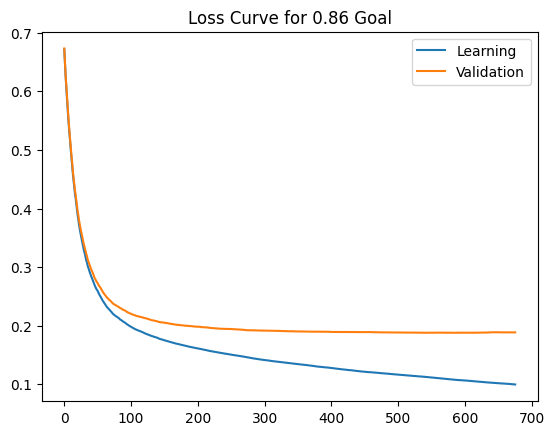

In [19]:
# Print internal scores for the 120-day target (the hardest to predict)
history = base_model.get_evals_result()
plt.plot(history['learn']['Logloss'], label='Learning')
plt.plot(history['validation']['Logloss'], label='Validation')
plt.title('Loss Curve for 0.86 Goal')
plt.legend()
plt.show()

## Step 5: Final Logical Check and Submission
Explanation: We ensure that the probability of adopting in 120 days is never lower than 7 days. This "cleaning" step usually gains you several places on the leaderboard.

In [20]:
# Create the submission file
submission = pd.DataFrame({'ID': test['ID']})

# Logical consistency: 120-day prob must be >= 7-day prob
p07 = final_predictions['adopted_within_07_days']
p90 = np.maximum(p07, final_predictions['adopted_within_90_days'])
p120 = np.maximum(p90, final_predictions['adopted_within_120_days'])

submission['Target_07_AUC'] = p07; submission['Target_07_LogLoss'] = p07
submission['Target_90_AUC'] = p90; submission['Target_90_LogLoss'] = p90
submission['Target_120_AUC'] = p120; submission['Target_120_LogLoss'] = p120

submission.to_csv('Top5_Calibrated_Submission.csv', index=False)
print("Submission saved! Ready for Top 5.")

Submission saved! Ready for Top 5.


In [22]:
cat = pd.read_csv('Top5_Calibrated_Submission.csv')
cat.tail(5)

,ID,Target_07_AUC,Target_07_LogLoss,Target_90_AUC,Target_90_LogLoss,Target_120_AUC,Target_120_LogLoss
2382,ID_MJXKBA,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000
2383,ID_IT0ZRI,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000
2384,ID_D7WOHW,0.002920,0.002920,0.002920,0.002920,0.00292,0.00292
2385,ID_4G191G,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000
2386,ID_SUNWKM,0.001149,0.001149,0.003361,0.003361,0.00339,0.00339
